<div style="background-color:#ddecfc; color:#100; padding:30px; border-radius:50px; max-width:1200px; margin:left;">

# Data Cleansing 

- Identifying and treating outliers
- Handling skewed distributions
- Addressing missing values


In [56]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
%matplotlib inline
from sklearn.preprocessing import RobustScaler

warnings.filterwarnings("ignore")




## <font color='Navy'> <h4>🔷 <u> Functions </u></h4>
- useful functions called along the code.

In [89]:
def plot_fraud_rate_by_bin(df, feature):
    """
    Plots fraud rate by quantile bins of a specified feature.
    """
    df[f"{feature}_bin"] = pd.qcut(df[feature], q=10, duplicates="drop")

    fraud_rate_by_bin = (
        df.groupby(f"{feature}_bin")
        .agg(fraud_rate=("is_fraud", "mean"),
            count=("is_fraud", "size"))
        .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(10, 5))

    sns.lineplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="fraud_rate",
        marker="o",
        color="blue",
        ax=ax1
    )
    ax1.set_ylabel("Fraud Rate", color="blue")
    ax1.set_xlabel(f"{feature.title()} (Quantile Bin)")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Add volume as bars
    ax2 = ax1.twinx()
    sns.barplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="count",
        alpha=0.3,
        color="gray",
        ax=ax2
    )
    ax2.set_ylabel("Transaction Count", color="gray")

    plt.title(f"Fraud Rate by {feature.title()} (Quantile Bins)")
    plt.tight_layout()
    plt.show()

    


In [90]:
def compare_tail_body(df, feature):
    p99 = df[feature].quantile(0.99)
    tail = df[df[feature] > p99]
    body = df[df[feature] <= p99]

    print(f"Fraud rate above 99th percentile: {tail['is_fraud'].mean():.3f}")
    print(f"Fraud rate below 99th percentile: {body['is_fraud'].mean():.3f}")
    print(f"Number of tail transactions: {len(tail)} ({len(tail)/len(df)*100:.2f}%)")

In [91]:
def check_skewness(df, features, threshold=1):
    """
    Computes skewness for each feature in a list and flags if it's highly skewed.

    Parameters:
        df (pd.DataFrame)
        features (list): list of numeric feature names
        threshold (float): cutoff to label strong skew (default=1)

    Returns:
        pd.DataFrame with feature, skewness value, and skew type
    """
    results = []
    for col in features:
        skew = df[col].skew()
        if skew > threshold:
            skew_type = "Right-skewed"
        elif skew < -threshold:
            skew_type = "Left-skewed"
        else:
            skew_type = "Approximately normal"
        results.append({"Feature": col, "Skewness": round(skew, 3), "Type": skew_type})
    
    skew_df = pd.DataFrame(results).sort_values(by="Skewness", ascending=False)
    return skew_df


## <font color='Navy'> <h4>🔷 <u> Data Load & Prep </u></h4>

### <font color='Navy'> 1🔹<u><b> File Load: </u></b> </h3>


In [92]:
df = pd.read_pickle("EDA_final.pkl")

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   gender            518772 non-null  category
 2   city              518772 non-null  category
 3   state             518772 non-null  category
 4   city_pop          518772 non-null  int64   
 5   acct_num          518772 non-null  int64   
 6   trans_time        518772 non-null  int32   
 7   unix_time         518772 non-null  int64   
 8   category          518772 non-null  category
 9   amt               518772 non-null  float64 
 10  is_fraud          518772 non-null  int64   
 11  merchant          518772 non-null  category
 12  trans_month       518772 non-null  category
 13  trans_quarter     518772 non-null  category
 14  trans_day         518772 non-null  int32   
 15  trans_dayofweek   518772 non-null  category
 16 

In [94]:
df.head(3)

,cc_num,gender,city,state,city_pop,acct_num,trans_time,unix_time,category,amt,...,age_group,location_profile,job_category,trans_time_group,distance_km,zip3,category_clean,is_online,category_type,zip_region
5428868,4087053319705536,m,Milwaukee,WI,817312,742734745331,16,1604488850,kids_pets,5.44,...,adults_2550,urban,other,Afternoon,71.77,532,kids_pets,0,kids_pets,5
27398503,6552516675384246,m,Hammond,LA,47940,646542117633,13,1601368114,kids_pets,7.30,...,young_adults,urban,arts/media,Afternoon,104.27,704,kids_pets,0,kids_pets,7
16559193,4973157083855870466,m,Jackson,MO,24006,938655990723,19,1595425347,home,27.57,...,adults_2550,urban,technology,Evening,92.24,637,home,0,home,6


### <font color='Navy'> 2🔹<u><b> Continuous Features : </u></b> </h3>


In [95]:
continues_features = ['amt', 'city_pop','age', 'distance_km']

- `amt` and `city_pop` were heavly skewed.
- `distance_km` and `age` were quite noraml.


## <font color='Navy'> <h4>🔷 <u> Outliers </u></h4>

### <font color='Navy'> 1🔹<u><b> Skewed Features</u></b> </h3>
- as presented in the EDA


In [96]:
# Recall skewness for numeric features, as presented in the EDA:
skewness_df = check_skewness(df, continues_features)
skewness_df

,Feature,Skewness,Type
0,amt,47.613,Right-skewed
1,city_pop,2.915,Right-skewed
2,age,0.691,Approximately normal
3,distance_km,-0.239,Approximately normal


### <font color='Navy'> 2🔹<u><b> Outlier % - IQR </u></b> </h3>
- as presented in the EDA

In [97]:
outlier_summary = {}
for col in continues_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = {
        "outlier_count": outlier_count,
        "outlier_%": outlier_count / len(df) * 100
    }

pd.DataFrame(outlier_summary).T


,outlier_count,outlier_%
amt,29308.0,5.649495
city_pop,83973.0,16.186880
age,6.0,0.001157
distance_km,0.0,0.000000


### <font color='Navy'> 3🔹<u><b> Outliers Visualization - BoxPlots </u></b> </h3>


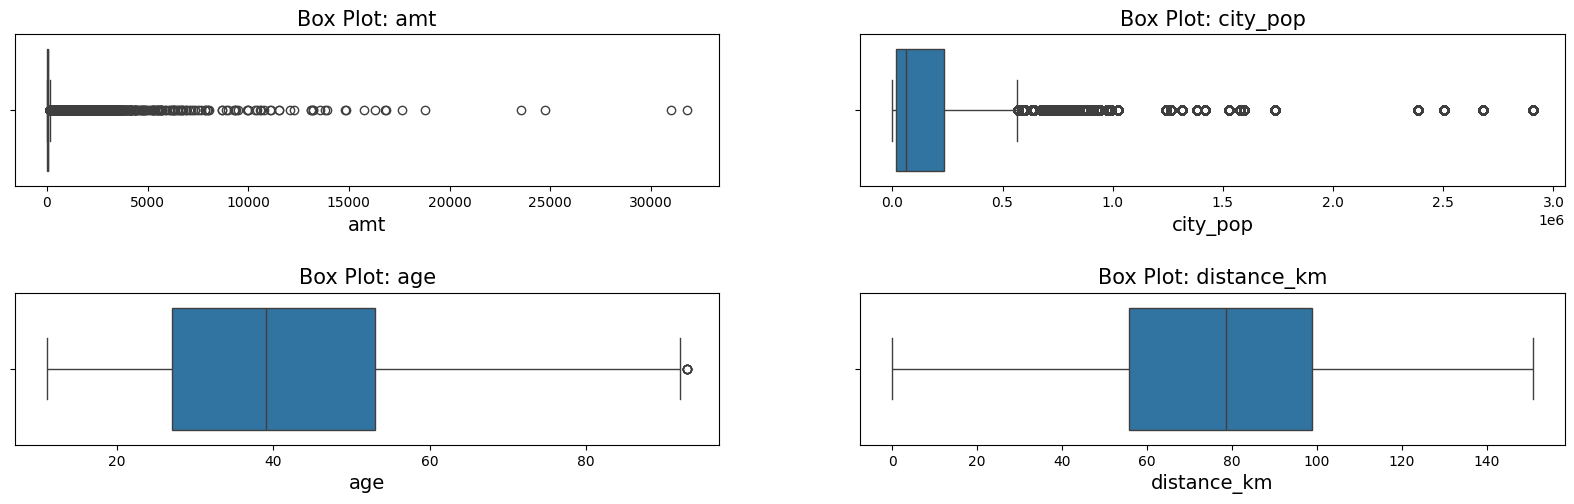

In [98]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        
            ax = plt.subplot(60, 2, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers_boxplot(df[continues_features])

- As expected, `amt` and `city_pop` which were Right-skewed show outlier markings.
    - However, since the data is skewed we must be careful before removing/capping that info as it may contain important predictive power.

### <font color='Navy'> 4🔹<u><b> Fraud rate validation</u></b> </h3>
- Ensure high/low values aren't discarded if predictive.

In [99]:
df_copy = df.copy()

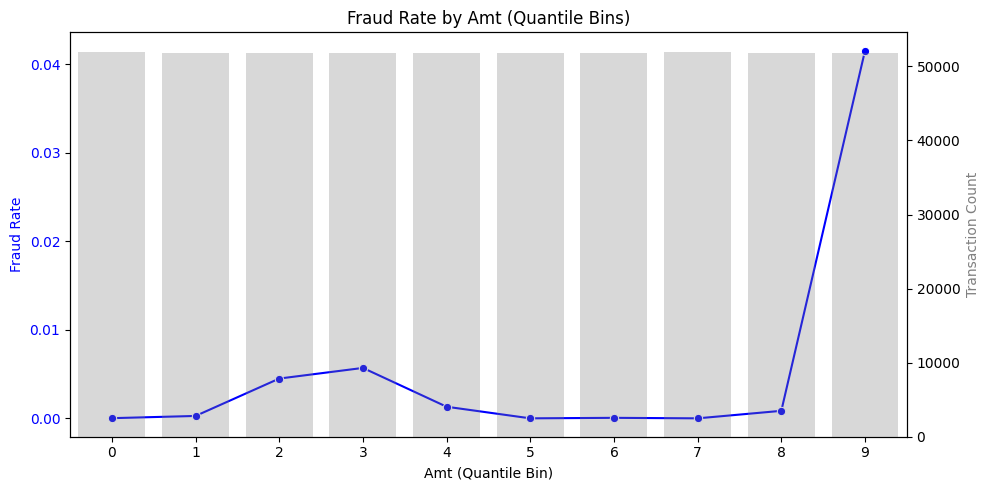

In [100]:
feature = "amt"
plot_fraud_rate_by_bin(df, feature)

- we can see that the top 10% of transactions amt (the 9th) has increased fraud rate.
- lower amounts have fairly stable rate.

This indicates that we should not remove what seems to be "outliers" or preform "capping" as this segement is  <b> likely holding a predictive power.</b>

<br>
Lets check fraud rate for the 99th precntile cut as well : </br>

In [101]:
compare_tail_body(df_copy, feature)

Fraud rate above 99th percentile: 0.272
Fraud rate below 99th percentile: 0.003
Number of tail transactions: 5188 (1.00%)


<font color='Navy'> Notes:
- Per above data, it is best to keep `amt` as it is.

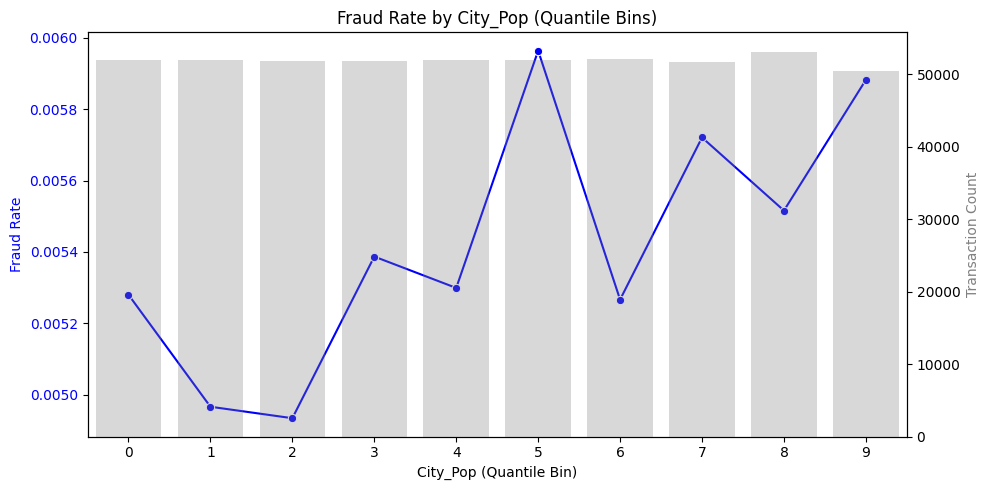

Fraud rate above 99th percentile: 0.004
Fraud rate below 99th percentile: 0.005
Number of tail transactions: 5076 (0.98%)


In [102]:
feature = "city_pop"
plot_fraud_rate_by_bin(df, feature)
compare_tail_body(df_copy, feature)

- The distribution of city_pop is highly right-skewed, with most transactions coming from smaller cities per EDA.
- Although the fraud density (count) appears higher in low-population cities, quantile-based analysis shows that the fraud rate remains roughly constant (≈ 0.5 %) across all city sizes.

- This suggests that city population does not meaningfully influence fraud likelihood.

<font color='Navy'> Notes:
- Therefore, no capping or special handling is required beyond potential log-scaling for normalization.

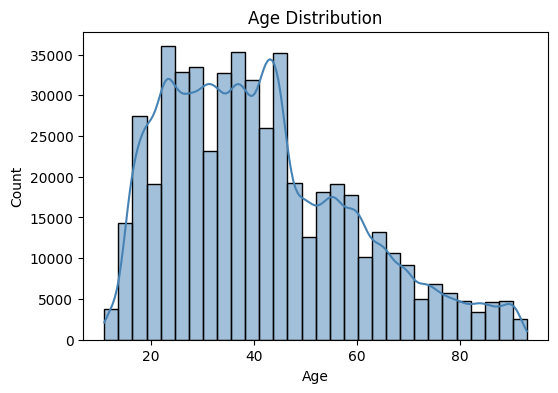

In [103]:
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=30, kde=True, color='steelblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()


In [104]:
Q1, Q3 = df['age'].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
df.loc[df['age'] > upper, ['age', 'is_fraud']].sort_values('age', ascending=False)


,age,is_fraud
26655600,93,0
32265376,93,0
11908626,93,0
26655690,93,0
26579492,93,0
26579282,93,0


- These appear valid rather than errors, seems like realistic human age range. 

In [105]:
feature = "distance_km"
# This feature is ditributed fairly normally with low skewness, and box plot shows no significant outliers, so no tail analysis needed.

In [106]:
outliers = df[df['age'] > upper]
body = df[df['age'] <= upper]

print("Fraud rate among age outliers:", outliers['is_fraud'].mean())
print("Fraud rate among non-outliers:", body['is_fraud'].mean())


Fraud rate among age outliers: 0.0
Fraud rate among non-outliers: 0.005420555703342162


## <font color='Navy'> <h4>🔷 <u> Nulls Verification </u></h4>

In [107]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

,Missing Count,Missing %


<Axes: >

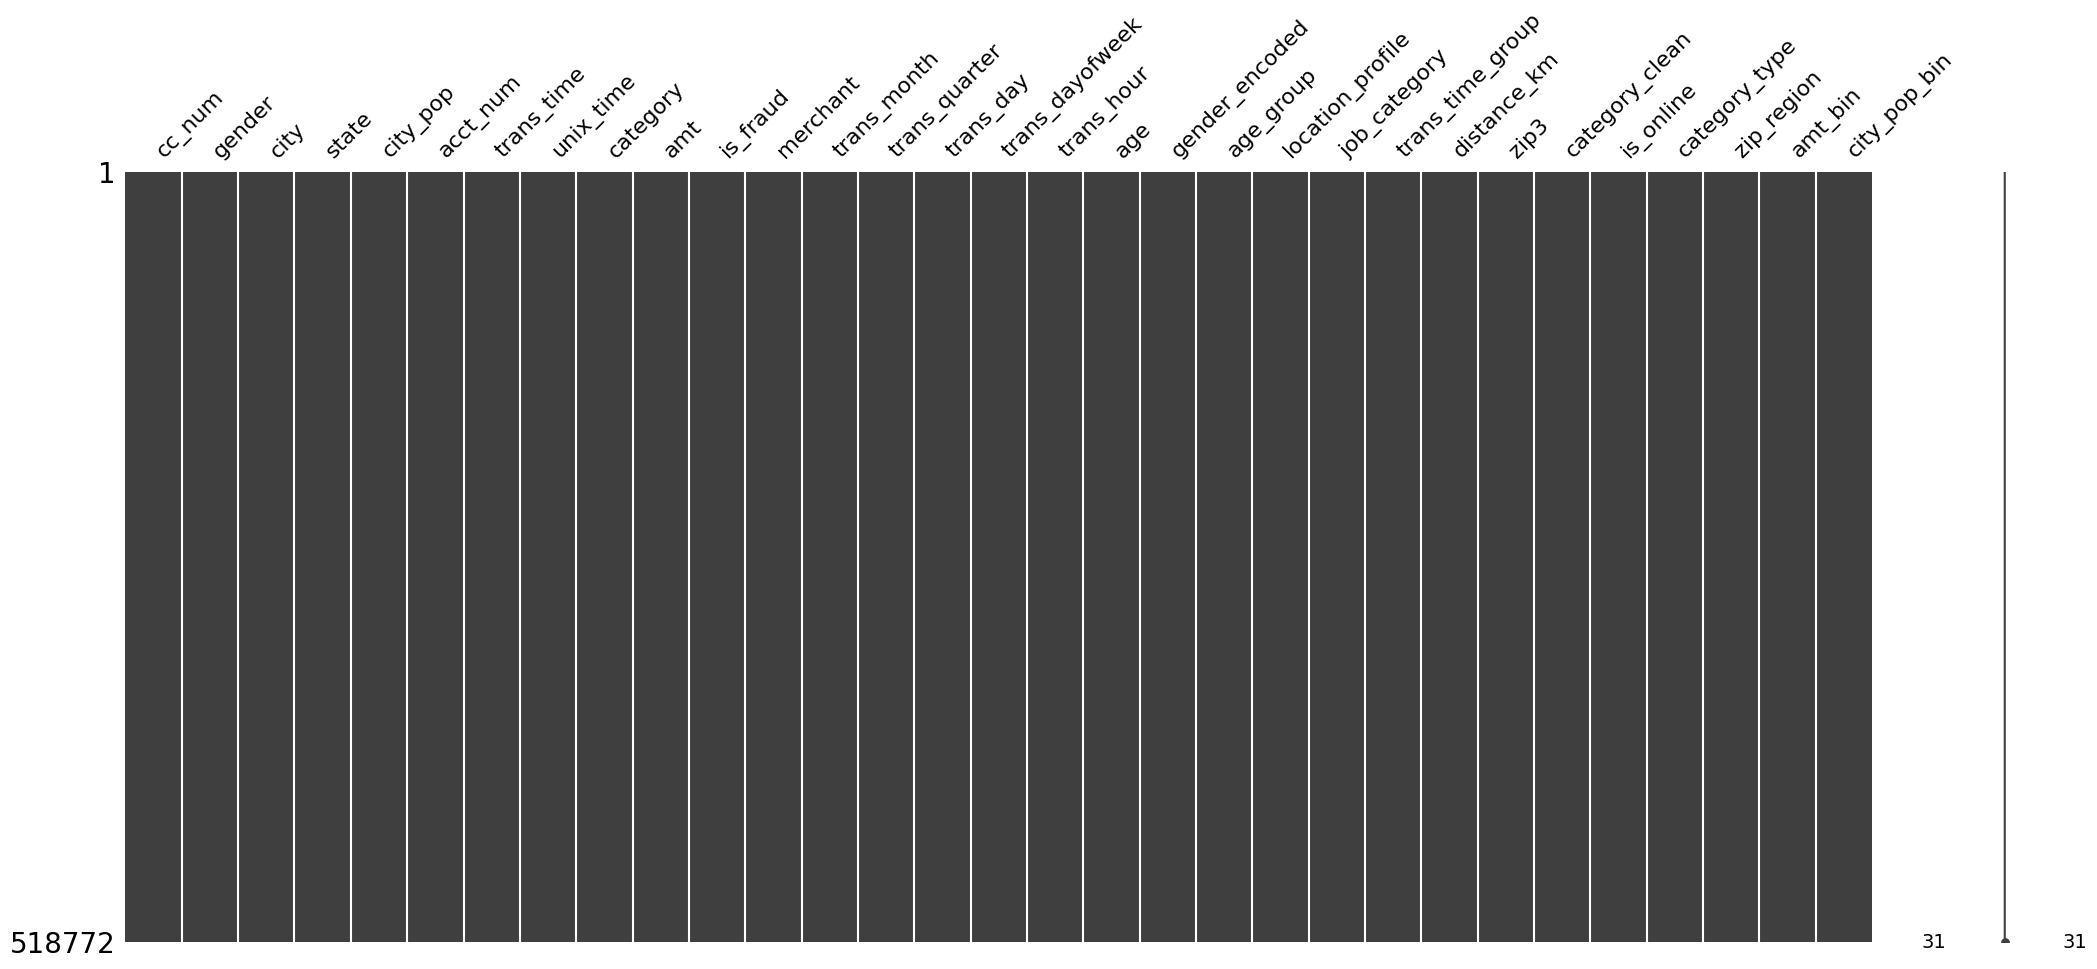

In [108]:
#Visualize missing data pattern
msno.matrix(df)

- The transformation reduces skewness and preserves meaningful variation, preparing these features for subsequent scaling and model input.

## <font color='Navy'> <h4>🔷 <u> Duplicate/Redundant Data Drops </u></h4>

In [109]:
cats_2drop= ['trans_quarter', 'trans_time_group'] # from EDA, we noticed it was 
cats_2drop.append('category_type') # duplicate
cats_2drop.append('gender') # duplicate post encoding
cats_2drop.append('zip3') # encoded/reduced to zip_region due to high cardinality
cats_2drop.append('unix_time') # redundant
# cats_2drop.append('cc_num') # we will use it in feature engineering.

In [110]:
cats_2drop

['trans_quarter',
 'trans_time_group',
 'category_type',
 'gender',
 'zip3',
 'unix_time']

In [111]:
df = df.drop(columns= cats_2drop)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   city              518772 non-null  category
 2   state             518772 non-null  category
 3   city_pop          518772 non-null  int64   
 4   acct_num          518772 non-null  int64   
 5   trans_time        518772 non-null  int32   
 6   category          518772 non-null  category
 7   amt               518772 non-null  float64 
 8   is_fraud          518772 non-null  int64   
 9   merchant          518772 non-null  category
 10  trans_month       518772 non-null  category
 11  trans_day         518772 non-null  int32   
 12  trans_dayofweek   518772 non-null  category
 13  trans_hour        518772 non-null  category
 14  age               518772 non-null  int64   
 15  gender_encoded    518772 non-null  int8    
 16 

In [113]:
#save to pkl file
df.to_pickle("Data_Cleansed.pkl")

## <font color='Navy'> <h4>🔷 <u> Handle Skewness </u></h4>

- some models can't hanlde a skewed data very well.

In [80]:
# Recall skewness for numeric features, as presented in the EDA:
skewness_df = check_skewness(df, continues_features)
skewness_df

,Feature,Skewness,Type
0,amt,47.613,Right-skewed
1,city_pop,2.915,Right-skewed
2,age,0.691,Approximately normal
3,distance_km,-0.239,Approximately normal


In [81]:
df['amt_log'] = np.log1p(df['amt']) # log(amt + 1)
df['city_pop_log'] = np.log1p(df['city_pop'])

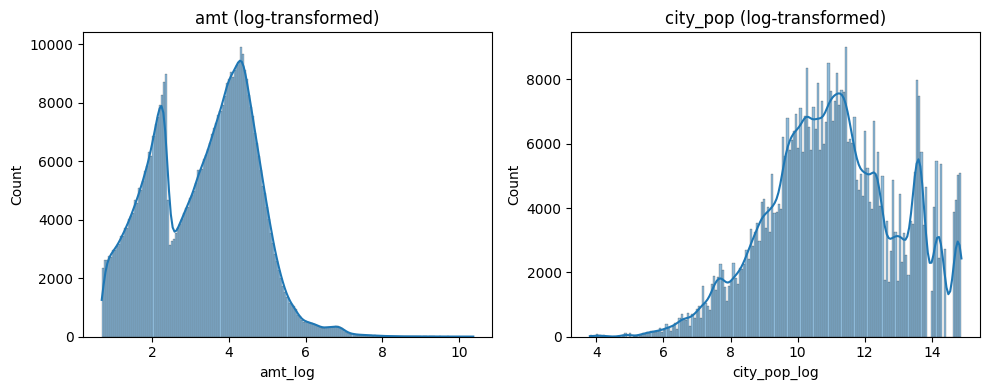

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['amt_log'], kde=True, ax=ax[0])
ax[0].set_title('amt (log-transformed)')
sns.histplot(df['city_pop_log'], kde=True, ax=ax[1])
ax[1].set_title('city_pop (log-transformed)')
plt.tight_layout()
plt.show()


### Scaling:
- This method scales features based on their median and IQR, making it resilient to residual outliers and suitable for non-normal data

In [177]:
# Select numeric features to scale (excluding target)
num_features = ['amt_log', 'city_pop_log', 'age', 'distance_km']

scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df_scaled[num_features])


In [178]:
df_scaled.head(3)

,cc_num,city,state,city_pop,acct_num,trans_time,category,amt,is_fraud,merchant,trans_month,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,age_group,location_profile,job_category,distance_km,category_clean,is_online,zip_region,amt_bin,city_pop_bin,amt_log,city_pop_log
5428868,4087053319705536,Milwaukee,WI,817312,742734745331,16,kids_pets,5.44,0,schimmelolson,11,4,2,16,0.192308,1,adults_2550,urban,other,-0.160462,kids_pets,0,5,"(3.65, 6.68]","(378909.0, 878243.0]",-0.785410,1.003334
27398503,6552516675384246,Hammond,LA,47940,646542117633,13,kids_pets,7.30,0,beerjast,9,29,1,13,-0.769231,1,young_adults,urban,arts/media,0.590983,kids_pets,0,7,"(6.68, 9.82]","(38295.0, 60892.0]",-0.666247,-0.092396
16559193,4973157083855870466,Jackson,MO,24006,938655990723,19,home,27.57,0,witting beer and ernser,7,22,2,19,-0.038462,1,adults_2550,urban,technology,0.312832,home,0,6,"(20.38, 33.29]","(23184.0, 38295.0]",-0.085710,-0.359611


Feature Scaling
After addressing outliers and applying log transformations to reduce skewness, numeric features were scaled to comparable ranges using a RobustScaler.
Although major outliers were already handled, some natural variance and mild tails remain, so a robust method (based on median and IQR) ensures stable scaling without being affected by those values.

# Validation :
- the shapes are improved (skew reduced),

- outliers are under control,

- and scaling aligned the magnitudes.

city_pop_log    -0.097191
amt_log         -0.012948
city_pop         2.915463
amt             47.612774
dtype: float64


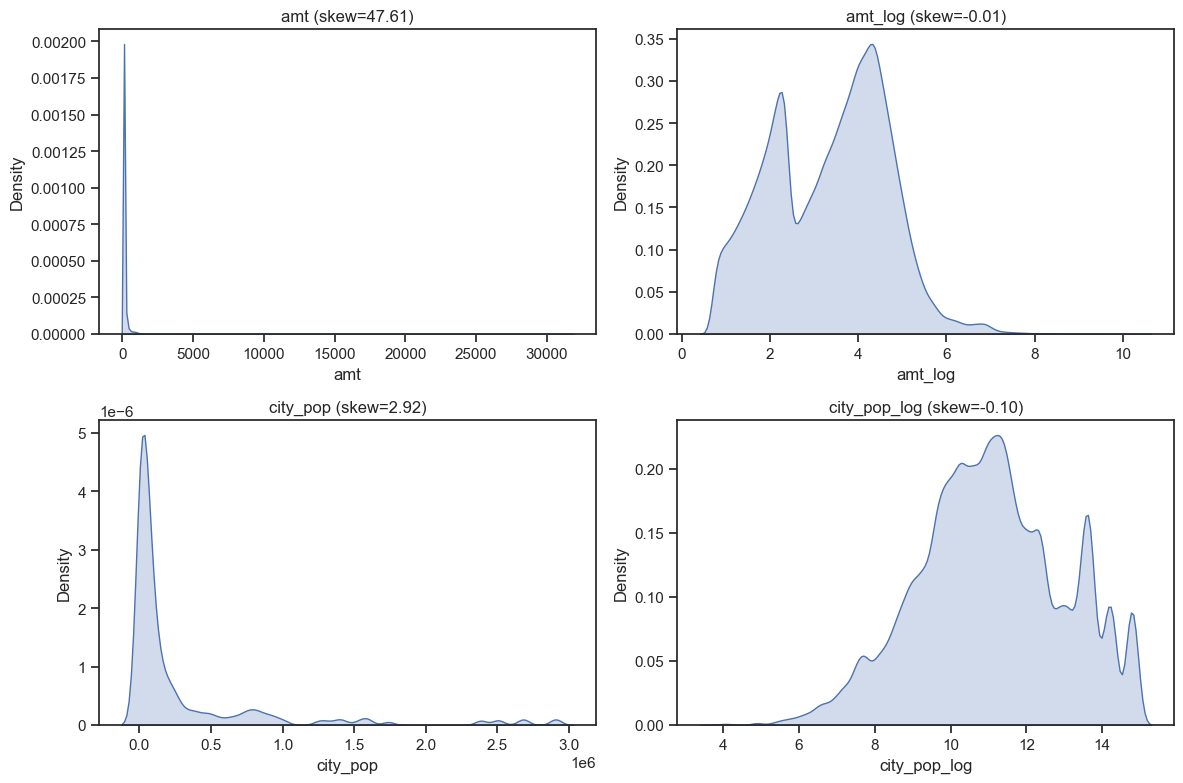

In [179]:
from scipy.stats import skew

features = ['amt', 'amt_log', 'city_pop', 'city_pop_log']
skewness = {f: skew(df[f].dropna()) for f in features}
print(pd.Series(skewness).sort_values())

# Visual validation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.kdeplot(df['amt'], ax=axes[0,0], fill=True)
axes[0,0].set_title(f"amt (skew={skew(df['amt']):.2f})")

sns.kdeplot(df['amt_log'], ax=axes[0,1], fill=True)
axes[0,1].set_title(f"amt_log (skew={skew(df['amt_log']):.2f})")

sns.kdeplot(df['city_pop'], ax=axes[1,0], fill=True)
axes[1,0].set_title(f"city_pop (skew={skew(df['city_pop']):.2f})")

sns.kdeplot(df['city_pop_log'], ax=axes[1,1], fill=True)
axes[1,1].set_title(f"city_pop_log (skew={skew(df['city_pop_log']):.2f})")

plt.tight_layout()
plt.show()


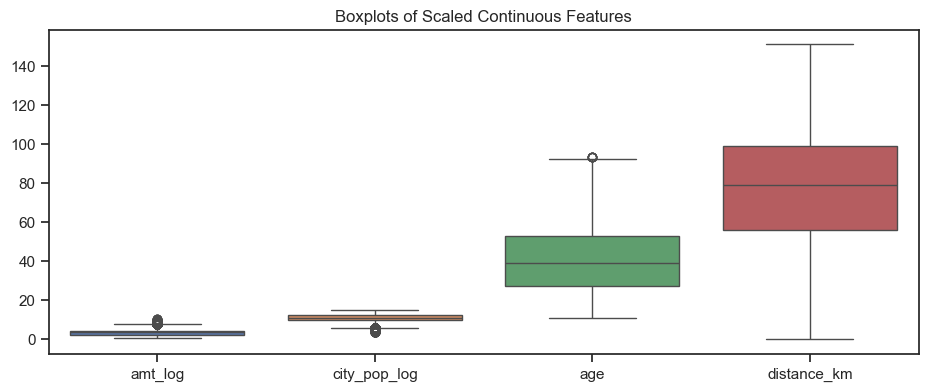

In [180]:
scaled_cols = ['amt_log', 'city_pop_log', 'age', 'distance_km']
plt.figure(figsize=(10, 4))
sns.boxplot(data=df[scaled_cols])
plt.title("Boxplots of Scaled Continuous Features")
plt.show()


Validation of Continuous Feature Transformations
The log transformation applied to amt and city_pop successfully reduced extreme right skewness (47.6 → -0.01 and 2.9 → -0.1, respectively).
Visual inspection confirmed smoother, more symmetric distributions without loss of important variation.
Boxplots of scaled features showed aligned magnitudes, indicating that scaling and transformation steps were effective.
These validated transformations ensure stable model training and balanced numeric representation across continuous variables.

In [181]:
#export in csv
df.to_csv("Data_Cleansed.csv", index=False)